# CoC Data Summarization
The number of people experiencing homelessness (PEP) is estimated every year during a point in time (PIT) count conducted in each continuum of care (CoC). The US Census Bureau conducts various surveys, including the 5-year American Community Survey, which collects critical data such as education, income, demographics, cost of living, fractions of the population receving assistance from government programs, and many others. 

The ACS5 survey provides high quality data at the census tract level. To associate the census features with CoCs, we represent a CoC as a combination of its constituent census tracts to create a data set consisting of PIT data and aggregated tract-level features.

In [6]:
import pandas as pd
from utils import *
from parameters import *
import openpyxl
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt

## Methods
CoCs can contain many US Census Bureau tracts. For each tract constituting a CoC, we note the fraction of the total tract encompassed in the CoC. Tracts of which less than 1% of the total tract area is within the CoC are omitted.

Algorithmically, this is done by performing intersections between shape files and then calculating the total area of overlap after converting to an area-preserving coordinate reference system. Note that tracts may change on an annual basis; therefore, these data must be generated for each year. 

This formulation can be expressed succinctly as:

$$
x_i = \sum_{t \in \mathcal{T}} \alpha_t x_{it}
$$

where $x_i$ is value of feature $i$ for the CoC in question, $x_{it}$ is the value of feature $i$ for a census tract $t$, $\mathcal{T}$ is the set of census tracts that intersect the CoC, and $\alpha_t \in [0.01, 1]$ is the geographic weighting of census tract $t$, i.e., how much of tract $t$ is in the CoC.

For median, per capita, or other averaged features, such as household income or property value, we perform a population-weighted linear combination of the census tracts:

$$
\bar{x}_i = \sum_{t \in \mathcal{T}} \beta_t \bar{x}_{it}
$$

where 

$$
\beta_{t} = \frac{\alpha_t\mathrm{population}_t}{\sum_{t\in\mathcal{T}} \alpha_t \mathrm{population}_t}.
$$

In all modeling, we assume a uniform distribution of the population within a census tract. The set of features selected for this analysis are defined in ```census_features``` in ```parameters.py```. The functions to execute the algorithm described herein are defined in ```utils.py```.

In [2]:
def process_census_data(year, census_api_key, states):
    return post_process_census_data(create_coc_summary(year, census_api_key, states))

In [ ]:
census_api_key = "85e4d04ebdc75be192b6cd5444f6dc9970a95666"

# # Test single year
summary_2023 = create_coc_summary(2023, census_api_key)


Processing 2023


In [12]:
summary_2023_processed = post_process_census_data(summary_2023)
summary_2023_processed['COCNUM'] = summary_2023_processed.index.str.replace('_', '-')
coc_gpd = create_cocs_graphs(2023)
coc_gpd_joined = coc_gpd.merge(
    summary_2023_processed,
    left_on='COCNUM',
    right_on='COCNUM',
    how='left'
)
# summary_processed = post_process_census_data(summary_2014)

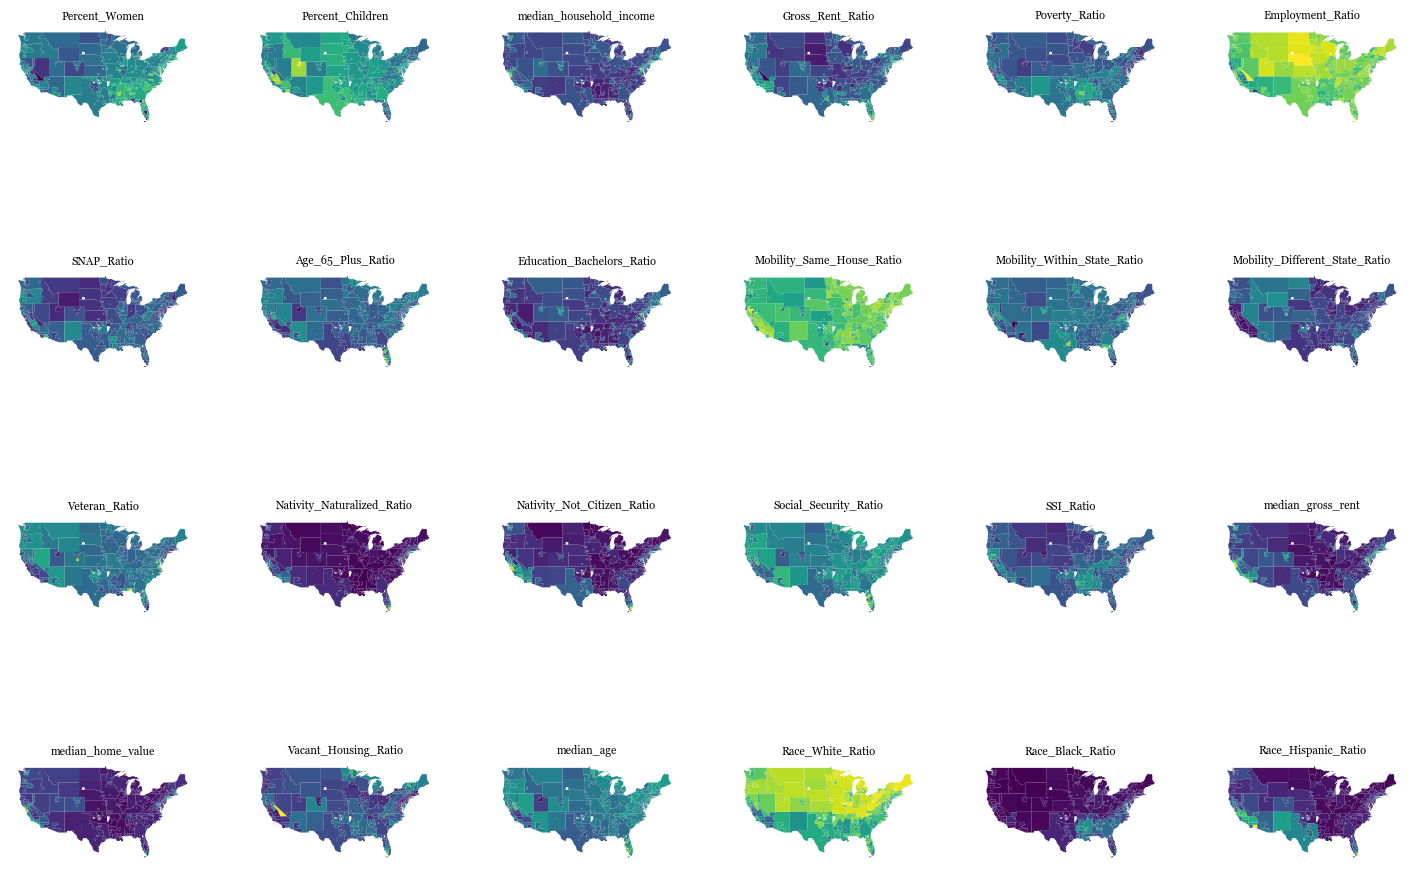

In [23]:
col_variables = [
    "Percent_Women",
    "Percent_Children",
    "median_household_income",
    "Gross_Rent_Ratio",
    "Poverty_Ratio",
    "Employment_Ratio",
    "SNAP_Ratio",
    "Age_65_Plus_Ratio",
    "Education_Bachelors_Ratio",
    "Mobility_Same_House_Ratio",
    "Mobility_Within_State_Ratio",
    "Mobility_Different_State_Ratio",
    "Veteran_Ratio",
    "Nativity_Naturalized_Ratio",
    "Nativity_Not_Citizen_Ratio",
    "Social_Security_Ratio",
    "SSI_Ratio",
    "median_gross_rent",
    "median_home_value",
    "Vacant_Housing_Ratio",
    "median_age",
    "Race_White_Ratio",
    "Race_Black_Ratio",
    "Race_Hispanic_Ratio"
]

plt.rcParams['font.family'] = 'Georgia'

# col_variables = ["Total Population"]

# for col in col_variables:
#     fig, ax = plt.subplots(
#         figsize = (10, 6),
#     )
    

fig, axes = plt.subplots(4, 6, figsize=(18, 12))  # 4 rows, 6 columns
axes = axes.flatten()  # Flatten to easily loop over

# Loop through variables
for i, var in enumerate(col_variables):
    ax = axes[i]
    
    coc_gpd_joined.plot(
        ax = ax,
        column = var
    )
    ax.set_title(var, fontsize=8)
    ax.set_axis_off()
    
    # x = np.arange(10)
    # y = np.random.rand(10)
    
    # ax.plot(x, y)
    # ax.set_title(var, fontsize=8)  # Small font for tight layout
    ax.tick_params(axis='both', labelsize=6)

# Hide any unused subplots (if variables < 24)
for j in range(len(col_variables), len(axes)):
    fig.delaxes(axes[j])

# plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3)  # smaller hspace = less vertical gap
# plt.show()



In [28]:
overall_homeless = pd.read_excel('coc-homelessness-data/processed_output.xlsx', sheet_name='2023')
overall_homeless['homeless_ratio'] = overall_homeless['Overall_Homeless']/overall_homeless['Total Population']
coc_homeless = coc_gpd.merge(
    overall_homeless,
    left_on='COCNUM',
    right_on='CoC_Number',
    how='left'
)

Text(0.5, 1.0, 'Homelessness Ratio')

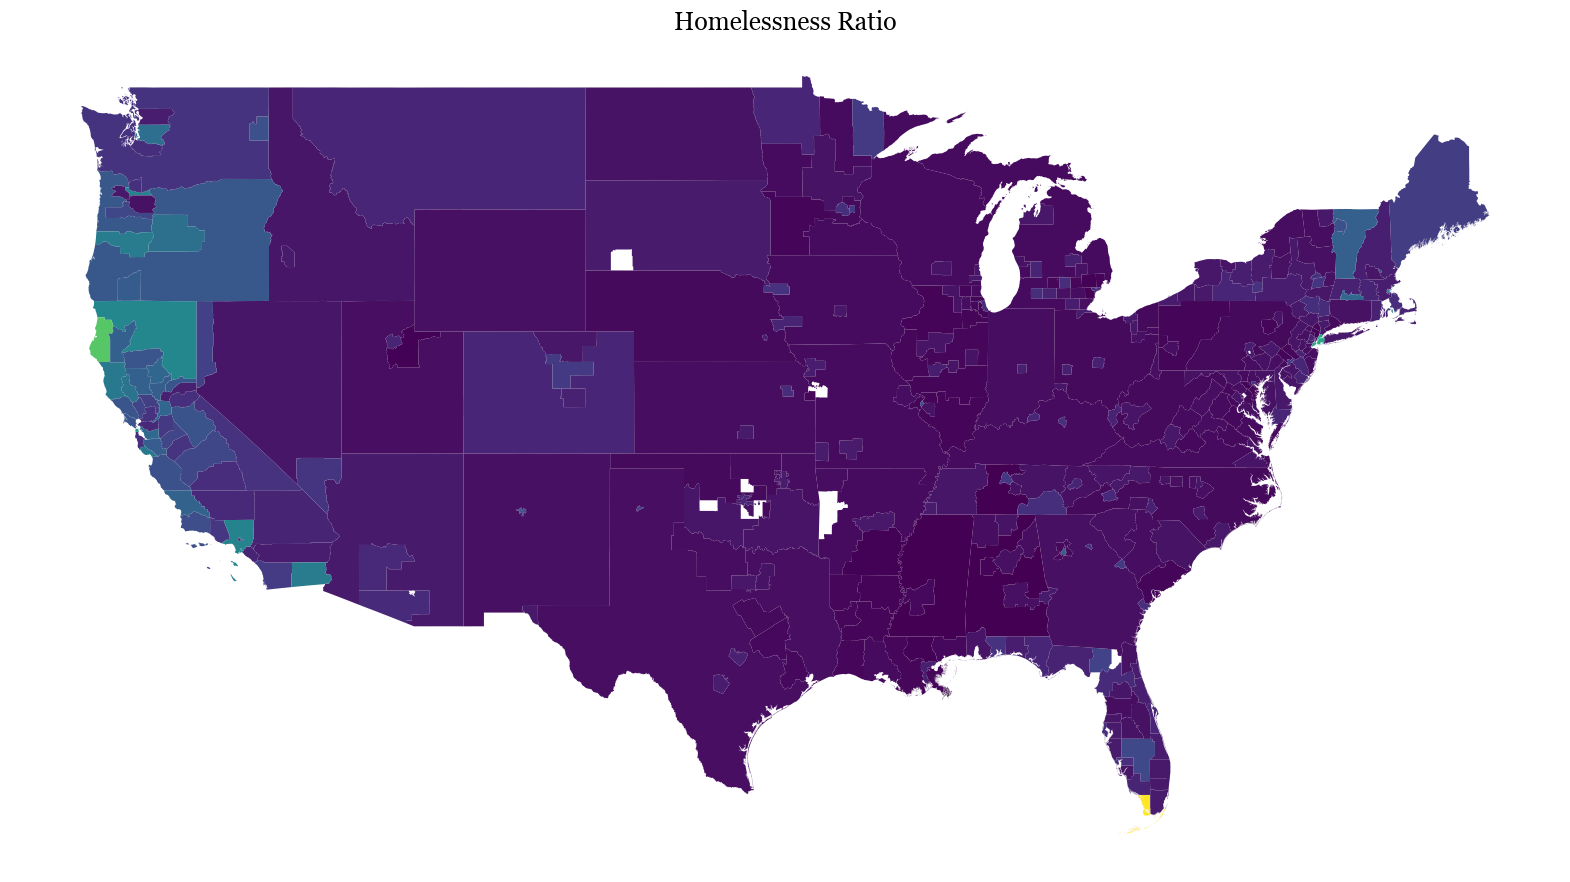

In [33]:
fig, ax = plt.subplots(figsize=(20, 12))
coc_homeless.plot(
    ax = ax,
    column="homeless_ratio"
)
ax.set_axis_off()
ax.set_title('Homelessness Ratio', fontsize = 18)

In [4]:
# summary_2014['age_65_pct'] = (summary_2014['age_65_plus_male'] + summary_2014['age_65_plus_female'])/summary_2014['age_total_population']*100
# summary_2014.to_excel('summary_2014.xlsx')

In [5]:
# Aggregate data over all years from 2011 through 2023; at the time of this work, data ACS5 for 2024 was not yet available.
years = range(2011, 2024)

# Execute queries in parallel
with ThreadPoolExecutor(max_workers=10) as parallel_executor:
    futures = []
    for year in years:
        futures.append(parallel_executor.submit(process_census_data, year, census_api_key, states))

with pd.ExcelWriter('coc_summary_6.xlsx') as writer:
    for yr, fut in zip(years, futures):
        try:
            df = fut.result()
            df.to_excel(writer, sheet_name=str(yr), index=True)
        except Exception as e:
            print(f"Year {yr}: {e}")

Processing 2011
Processing 2012
Processing 2013
Processing 2014
Processing 2015
Processing 2016
Processing 2017
Processing 2018
Processing 2019
Processing 2020
Processing 2021
Processing 2022
Processing 2023
